1. Value-based methods with deep neural network [50 points]
Implement Q-learning and Exptected SARSA for both Acrobot-v1 1 and ALE/Assault-ram-v52
environments from the Gym suite using the following guidelines:
• Use a Neural Network approximation for Q, that is, if x is a vector representing the state
and a is the action vector, use Q value(x) = M LP (x; θ), where θ are the parameters of the
Value function you need to learn, Q ∈ Rm where m denotes the number of discrete actions.
• Model configuration: Initialize the parameters for the value function uniformly between
−0.001 and 0.001, we recommend using either a 2 or 3-layer Neural Network for the Value
function, with a hidden dimension of 256.
• Use an ϵ- greedy policy with three choices of ϵ and step-size parameters 1/4, 1/8, 1/16. and
run 50 learning trials with different initializations for the Value function, each having 1000
episodes, for each configuration. That means 3(ϵ’s) * 3 (step-sizes) * 50 runs * 1000 episodes.
• Repeat the Previous step using a replay buffer (with transitions randomly sampled) and do
gradient updates using a mini-batch of transitions. The capacity of the replay buffer is 1M.
• Plot training curves with the mean across seeds as lines and the standard deviation as a shaded
region. (Performance on the Y-axis, and the episode on the X-axis). Generate 18 graphs
covering all configurations per environment. Present separate plots for each environment,
with distinct graphs for settings with and without a replay buffer. Use green for Q-Learning
and red for Expected SARSA, differentiating hyperparameters with different line styles (e.g.,
solid, dashed).
• Implement all the methods using any automatic differentiation package, such as Py-
torch

In [1]:
# Implement Q-learning and Exptected SARSA for both Acrobot-v1 1 and ALE/Assault-ram-v52 environments from the Gym suite using the following guidelines:

# • Use a Neural Network approximation for Q, that is, if x is a vector representing the state and a is the action vector, use Q value(x) = M LP (x; θ), where θ are the parameters of the Value function you need to learn, Q ∈ Rm where m denotes the number of discrete actions.

# • Model configuration: Initialize the parameters for the value function uniformly between −0.001 and 0.001, we recommend using either a 2 or 3-layer Neural Network for the Value function, with a hidden dimension of 256.

# • Use an ϵ- greedy policy with three choices of ϵ and step-size parameters 1/4, 1/8, 1/16. and run 50 learning trials with different initializations for the Value function, each having 1000 episodes, for each configuration. That means 3(ϵ’s) * 3 (step-sizes) * 50 runs * 1000 episodes.

# • Repeat the Previous step using a replay buffer (with transitions randomly sampled) and do gradient updates using a mini-batch of transitions. The capacity of the replay buffer is 1M.

# • Plot training curves with the mean across seeds as lines and the standard deviation as a shaded region. (Performance on the Y-axis, and the episode on the X-axis). Generate 18 graphs covering all configurations per environment. Present separate plots for each environment, with distinct graphs for settings with and without a replay buffer. Use green for Q-Learning and red for Expected SARSA, differentiating hyperparameters with different line styles (e.g., solid, dashed).

# • Implement all the methods using any automatic differentiation package, such as Py-torch

In [2]:
# env_name = 'Acrobot-v1'
env_name = 'ALE/Assault-ram-v5'

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import time
import pickle

# Hyperparameters
EPISODES = 1000
MAX_STEPS = 1000
GAMMA = 0.99
HIDDEN_DIM = 256
SEEDS = 10

# Environment
env = gym.make(env_name)
env._max_episode_steps = MAX_STEPS

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "mps"

# Neural Network
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, action_dim)

        # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Linear):
                print("initializing layer", m)
                nn.init.uniform_(m.weight, -0.01, 0.01)
                nn.init.uniform_(m.bias, -0.01, 0.01)

    def forward(self, x):
        x = x / 255.0
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Q-Learning
def q_learning(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
    q_network_target = QNetwork()
    q_network_target.load_state_dict(q_network.state_dict())
    q_network.to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                next_q_values = q_network_target(next_state_batch)
                # next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # for i in range(batch_size):
                #     target_q_values[i][action_batch[i]] = reward_batch[i] + GAMMA * next_q_values[i].max() * (1 - done_batch[i])
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * next_q_values.max(dim=1).values * (1 - done_batch)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 10 == 0:
            q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())

    return rewards

# Expected SARSA
def expected_sarsa(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
    q_network_target = QNetwork()
    q_network_target.load_state_dict(q_network.state_dict())
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                next_q_values = q_network_target(next_state_batch)
                # next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # expected sarsa
                probs = torch.ones(batch_size, action_dim) * epsilon / action_dim
                probs[range(batch_size), next_q_values.argmax(dim=1)] += 1 - epsilon
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * (probs * next_q_values).sum(dim=1) * (1 - done_batch)

                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 10 == 0:
            q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())
    return rewards


def run_experiment(lr, batch_size, replay_buffer_size, epsilon, seeds):
    random_seeds = [0, 1, 2, 3, 4, 5, 6, 8, 11, 12]
    print(seeds)
    q_learning_rewards = np.zeros((seeds, EPISODES))
    expected_sarsa_rewards = np.zeros((seeds, EPISODES))
    if os.path.exists(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        old_q_learning_rewards = pickle.load(open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
        q_learning_rewards[:min(old_q_learning_rewards.shape[0], seeds)] = old_q_learning_rewards[:min(old_q_learning_rewards.shape[0], seeds)]
    if os.path.exists(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        old_expected_sarsa_rewards = pickle.load(open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
        expected_sarsa_rewards[:min(old_expected_sarsa_rewards.shape[0], seeds)] = old_expected_sarsa_rewards[:min(old_expected_sarsa_rewards.shape[0], seeds)]
    # for i, seed in enumerate(random_seeds):
    for i in range(seeds):
        print(f'Run {i+1}/{seeds}')
        if q_learning_rewards[i].sum() == 0:
            print('Q-Learning')
            q_learning_rewards[i] = q_learning(lr, batch_size, replay_buffer_size, epsilon)
            pickle.dump(q_learning_rewards, open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        if expected_sarsa_rewards[i].sum() == 0:
            print('Expected SARSA')
            expected_sarsa_rewards[i] = expected_sarsa(lr, batch_size, replay_buffer_size, epsilon)
            pickle.dump(expected_sarsa_rewards, open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        q_learning_rewards_mean = q_learning_rewards[:i+1].mean(axis=0)
        q_learning_rewards_std = q_learning_rewards[:i+1].std(axis=0)
        expected_sarsa_rewards_mean = expected_sarsa_rewards[:i+1].mean(axis=0)
        expected_sarsa_rewards_std = expected_sarsa_rewards[:i+1].std(axis=0)
        plt.plot(q_learning_rewards_mean, label='Q-Learning', color='green')
        plt.fill_between(range(EPISODES), q_learning_rewards_mean - q_learning_rewards_std, q_learning_rewards_mean + q_learning_rewards_std, color='green', alpha=0.2)
        plt.plot(expected_sarsa_rewards_mean, label='Expected SARSA', color='red')
        plt.fill_between(range(EPISODES), expected_sarsa_rewards_mean - expected_sarsa_rewards_std, expected_sarsa_rewards_mean + expected_sarsa_rewards_std, color='red', alpha=0.2)
        plt.title(f'lr={lr}, batch_size={batch_size}, replay_buffer_size={replay_buffer_size}, epsilon={epsilon}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.savefig(f'plot_{i}_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.png')
        plt.show()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# SEEDS = 1
# EPISODES = 1000
# run_experiment(0.001, 128, 1000000, 0.25)

0.0001 32 1000000 0.25
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)


/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0 126.0 0.003928137011826038
10 210.0 1.8146321773529053
20 399.0 1.664935827255249
30 399.0 1.6783517599105835
40 252.0 0.11752704530954361
50 420.0 2.9209423065185547
60 357.0 0.08160822093486786
70 252.0 0.0679195374250412
80 315.0 1.0093916654586792
90 315.0 0.06897712498903275
100 378.0 0.13388080894947052
110 294.0 0.16688521206378937
120 378.0 0.21346697211265564
130 378.0 0.2635437846183777
140 420.0 0.12597228586673737
150 336.0 0.4266398251056671
160 399.0 0.2154112160205841
170 315.0 0.3110666871070862
180 357.0 2.137829303741455
190 378.0 0.18780939280986786
200 420.0 0.12693341076374054
210 357.0 0.23935678601264954
220 315.0 0.34385499358177185
230 189.0 2.517172336578369
240 441.0 0.6713413596153259
250 294.0 0.11196508258581161
260 189.0 0.11314965039491653
270 378.0 1.211539387702942
280 420.0 1.3485668897628784
290 441.0 0.17578376829624176
300 357.0 2.0119590759277344
310 336.0 0.15847910940647125
320 378.0 0.455187052488327
330 420.0 1.5598729848861694
340 189.0 1.5

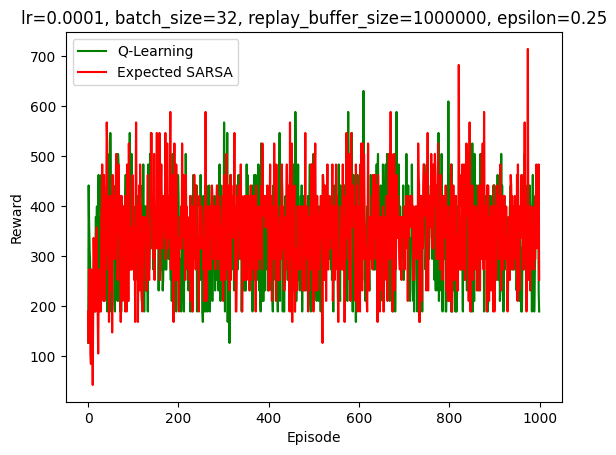

0.0001 32 1000000 0.1
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 336.0 0.000440050644101575
10 210.0 0.051549967378377914
20 357.0 0.05075881630182266
30 378.0 1.636630654335022
40 252.0 1.409667730331421
50 273.0 0.046628840267658234
60 294.0 0.06237367168068886
70 441.0 2.499455213546753
80 378.0 0.2382674366235733
90 273.0 2.233869791030884
100 294.0 1.389512300491333
110 420.0 0.028905659914016724
120 189.0 0.10717984288930893
130 525.0 0.10102967172861099
140 378.0 0.16139380633831024
150 336.0 1.6372159719467163
160 357.0 1.0753049850463867
170 294.0 1.4690656661987305
180 336.0 

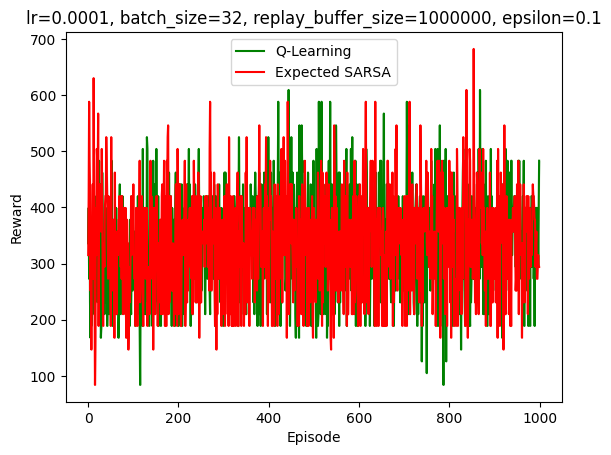

0.0001 32 1000000 0.01
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 21.0 8.129957677738275e-06
10 0.0 5.170895747141913e-06
20 0.0 2.2621990865445696e-05
30 0.0 2.423918340355158e-05
40 63.0 0.00505862757563591
50 399.0 1.730499267578125
60 315.0 1.7179219722747803
70 252.0 4.532172203063965
80 315.0 0.042331043630838394


KeyboardInterrupt: 

In [4]:
epsilons = [0.25, 0.1, 0.01]
# lrs = [1/4, 1/8, 1/16]
lrs = [0.0001, 0.001, 0.01] # 0.01
replay_buffers = [(32, 1000000), (1, 1)]
for i in range(1, 11):
    for replay_buffer in replay_buffers:
        for lr in lrs:
            for epsilon in epsilons:
                print(lr, replay_buffer[0], replay_buffer[1], epsilon)
                run_experiment(lr, replay_buffer[0], replay_buffer[1], epsilon, i)
